# 1 Dependency import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
def dataframe_distribution_overview(data, figsize=(10, 3)):
    plt.figure(figsize=figsize)

    sns.barplot(x=data.columns, y=data.count())

    plt.title("Number of values per column", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.ylabel("Number values", size=16)
    plt.show()

In [3]:
def index_lth(data, percentage: int):
    percentage = percentage / 100
    less_than = data.count() < data.shape[0] * percentage
    index_less_than = less_than[less_than == True].index
    return index_less_than

In [163]:
def multi_boxplot(data, features, n_cols=8, figsize=(30, 10), wspace=0.35, hspace=0.35):
    feature_nb = len(features)
    n_rows = ceil(feature_nb / n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for r in range(n_rows):
        for c in range(n_cols):
            if index >= feature_nb:
                break

            plt.subplot(n_rows, n_cols, index+1)

            feature = features[index]
            boxplot = sns.boxplot(y=data[feature])

            boxplot.set_xlabel(feature, fontsize=12)
            boxplot.set_ylabel(None)

            index += 1

    plt.show()

In [5]:
def create_subplot(dataset, feature, n_rows, index, is_numeric):
    plt.subplot(n_rows, 2, index)
    uniques = dataset[feature].unique()

    if is_numeric:
        plot = sns.boxplot(y=dataset[feature])
    else:
        if uniques.size <= 20 and uniques.size > 0:
            plot = sns.countplot(x=dataset[feature])
            plt.xticks(rotation=45, size=8, ha="right")
        else:
            dist = pd.DataFrame(data=[[uniques.size, dataset.shape[0] - uniques.size]], columns=["uniques", "not_uniques"])
            plot = sns.barplot(data=dist)

    plot.set_xlabel(None)
    plot.set_ylabel(feature, fontsize=14)


def dataset_diff_analysis(data1, data2, exclude=[], figsize=(15, 200)):
    features = data1.columns.union(data2.columns).difference(exclude)
    n_cols = 2
    n_rows = len(features)
    col_id = 0
    index = 1

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.35, hspace=0.5)

    for f in features:
        is_numeric = False
        if f in data1.columns:
            f_type = data1[f].dtype
        else:
            f_type = data2[f].dtype
        if f_type in ["int64", "float64"]:
            is_numeric = True

        if f in data1.columns.values:
            create_subplot(data1, f, n_rows, index, is_numeric)
        if f in data2.columns.values:
            create_subplot(data2, f, n_rows, index+1, is_numeric)

        index += 2

    print(f"features: {features}")
    plt.show()

In [6]:
def decribe_several(feature, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.describe()

In [7]:
def head_several(feature, nb, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.head(nb)

In [8]:
class OutlierProcessor():
    def __init__(self, data, feature, lower_trig, upper_trig):
        self.data = data
        self.feature = feature
        self.lower_trig = lower_trig
        self.upper_trig = upper_trig
        self.__above = 0
        self.__below = 0
        self.__total = 0

    def __print(self):
        print(f"lower_trig: {self.lower_trig}")
        print(f"upper_trig: {self.upper_trig}")
        print(f"below: {self.__below}")
        print(f"above: {self.__above}")
        print(f"total: {self.__total}")

    def count(self):
        self.__below = self.data[self.data[self.feature] < self.lower_trig][self.feature].count()
        self.__above = self.data[self.data[self.feature] > self.upper_trig][self.feature].count()
        self.__total = self.__below + self.__above
        self.__print()

    def replace(self, replace_by=np.nan, inplace=False):
        return self.data[self.feature].where(cond=lambda x: ((x > self.lower_trig) & (self.upper_trig > x)), other=replace_by, inplace=inplace)


In [9]:
class OutlierIqrProcessor(OutlierProcessor):
    def __init__(self, data, feature):
        self.__q1 = data[feature].quantile(0.25)
        self.__q3 = data[feature].quantile(0.75)
        self.__iqr = self.__q3 - self.__q1
        upper_trig = self.__q3 + (1.5 * self.__iqr)
        lower_trig = self.__q1 - (1.5 * self.__iqr)
        super().__init__(data, feature, lower_trig, upper_trig)


***
# 2 Data loading

## 2.1 Loading

In [10]:
data = pd.read_csv("data/2015-building-energy-benchmarking.csv", delimiter=",")

In [11]:
data2 = pd.read_csv("data/2016-building-energy-benchmarking.csv", delimiter=",")

***
## 2.2 Merge preparation

features: Index(['2010 Census Tracts', 'Address', 'BuildingType', 'City',
       'City Council Districts', 'ComplianceStatus', 'CouncilDistrictCode',
       'DataYear', 'DefaultData', 'ENERGYSTARScore', 'Electricity(kBtu)',
       'Electricity(kWh)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'Latitude',
       'ListOfAllPropertyUseTypes', 'Location', 'Longitude',
       'NaturalGas(kBtu)', 'NaturalGas(therms)', 'Neighborhood',
       'NumberofBuildings', 'NumberofFloors', 'OSEBuildingID',
       'OtherFuelUse(kBtu)', 'Outlier', 'PrimaryPropertyType',
       'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal',
       'PropertyName', 'SPD Beats',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(k

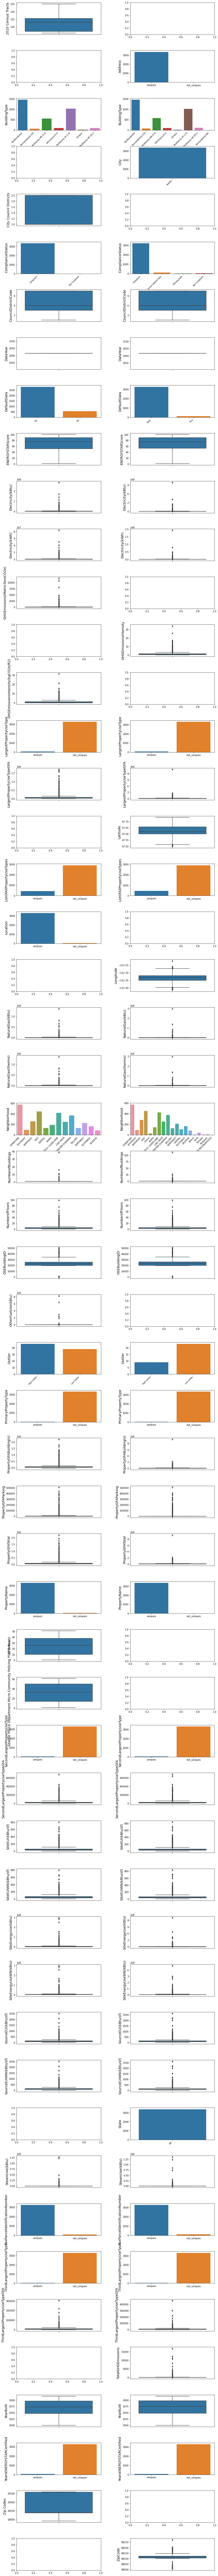

In [12]:
dataset_diff_analysis(data, data2, exclude=["Comment", "Comments"], figsize=(15, 200))

***
### 2.2.1 '2010 Census Tracts'

In [13]:
feature = "2010 Census Tracts"

In [14]:
data[feature].describe()

count    224.000000
mean     123.062500
std        5.812128
min      116.000000
25%      117.000000
50%      123.000000
75%      125.500000
max      135.000000
Name: 2010 Census Tracts, dtype: float64

***
### 2.2.2 Address

In [15]:
feature = "Address"

In [16]:
data2[feature].describe()

count                  3376
unique                 3354
top       2600 SW Barton St
freq                      4
Name: Address, dtype: object

***
### 2.2.3 BuildingType

In [17]:
feature = "BuildingType"

In [18]:
decribe_several(feature, data, data2)

,BuildingType_1,BuildingType_2
count,3340,3376
unique,7,8
top,NonResidential,NonResidential
freq,1461,1460


***
### 2.2.4 City

In [19]:
feature = "City"

In [20]:
data2[feature].describe()

count        3376
unique          1
top       Seattle
freq         3376
Name: City, dtype: object

***
### 2.2.5 'City Council Districts'

In [21]:
feature = "City Council Districts"

In [22]:
data[feature].describe()

count    213.000000
mean       1.347418
std        0.477272
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: City Council Districts, dtype: float64

***
### 2.2.6 ComplicanceStatus

In [23]:
feature = "ComplianceStatus"

In [24]:
decribe_several(feature, data, data2)

,ComplianceStatus_1,ComplianceStatus_2
count,3340,3376
unique,2,4
top,Compliant,Compliant
freq,3337,3211


***
### 2.2.7 CouncilDistrictCode

In [25]:
feature = "CouncilDistrictCode"

In [26]:
decribe_several(feature, data, data2)

,CouncilDistrictCode_1,CouncilDistrictCode_2
count,3340.000000,3376.000000
mean,4.450898,4.439277
std,2.127203,2.120625
min,1.000000,1.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,7.000000,7.000000
max,7.000000,7.000000


In [27]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.8 DataYear

In [28]:
feature = "DataYear"

In [29]:
decribe_several(feature, data, data2)

,DataYear_1,DataYear_2
count,3340.0,3376.0
mean,2015.0,2016.0
std,0.0,0.0
min,2015.0,2016.0
25%,2015.0,2016.0
50%,2015.0,2016.0
75%,2015.0,2016.0
max,2015.0,2016.0


***
### 2.2.9 DefaultData

In [30]:
feature = "DefaultData"

In [31]:
decribe_several(feature, data, data2)

,DefaultData_1,DefaultData_2
count,3339,3376
unique,2,2
top,No,False
freq,2791,3263


***
### 2.2.10 ENERGYSTARScore

In [32]:
feature = "ENERGYSTARScore"

In [33]:
decribe_several(feature, data, data2)

,ENERGYSTARScore_1,ENERGYSTARScore_2
count,2560.000000,2533.000000
mean,67.894141,67.918674
std,27.154057,26.873271
min,1.000000,1.000000
25%,51.750000,53.000000
50%,76.000000,75.000000
75%,90.000000,90.000000
max,100.000000,100.000000


In [34]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.11 Electricity(kBtu)

In [35]:
feature = "Electricity(kBtu)"

In [36]:
decribe_several(feature, data, data2)

,Electricity(kBtu)_1,Electricity(kBtu)_2
count,3.330000e+03,3.367000e+03
mean,3.473209e+06,3.707612e+06
std,9.519639e+06,1.485066e+07
min,0.000000e+00,-1.154170e+05
25%,6.363322e+05,6.394870e+05
50%,1.160236e+06,1.177583e+06
75%,2.750847e+06,2.829632e+06
max,2.847263e+08,6.570744e+08


***
### 2.2.12 Electricity(kWh)

In [37]:
feature = "Electricity(kWh)"

In [38]:
decribe_several(feature, data, data2)

,Electricity(kWh)_1,Electricity(kWh)_2
count,3.330000e+03,3.367000e+03
mean,1.017897e+06,1.086639e+06
std,2.789931e+06,4.352478e+06
min,0.000000e+00,-3.382680e+04
25%,1.864908e+05,1.874229e+05
50%,3.400320e+05,3.451299e+05
75%,8.061935e+05,8.293178e+05
max,8.344505e+07,1.925775e+08


***
### 2.2.13 GHGEmissions(MetricTonsCO2e)

In [39]:
feature = "GHGEmissions(MetricTonsCO2e)"

In [40]:
data[feature].describe()

count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

***
### 2.2.14 GHGEmissionsIntensity

In [41]:
feature = "GHGEmissionsIntensity"

In [42]:
data2[feature].describe()

count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64

***
### 2.2.15 GHGEmissionsIntensity(KgCO2e/ft2)

In [43]:
feature = "GHGEmissionsIntensity(kgCO2e/ft2)"

In [44]:
data[feature].describe()

count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64

***
### 2.2.16 LargestPropertyUseType

In [45]:
feature = "LargestPropertyUseType"

In [46]:
decribe_several(feature, data, data2)

,LargestPropertyUseType_1,LargestPropertyUseType_2
count,3204,3356
unique,56,56
top,Multifamily Housing,Multifamily Housing
freq,1598,1667


In [47]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.17 LargestPropertyUseTypeGFA

In [48]:
feature = "LargestPropertyUseTypeGFA"

In [49]:
decribe_several(feature, data, data2)

,LargestPropertyUseTypeGFA_1,LargestPropertyUseTypeGFA_2
count,3.204000e+03,3.356000e+03
mean,7.488154e+04,7.917764e+04
std,1.236249e+05,2.017034e+05
min,5.872000e+03,5.656000e+03
25%,2.500000e+04,2.509475e+04
50%,3.900000e+04,3.989400e+04
75%,7.206750e+04,7.620025e+04
max,1.719643e+06,9.320156e+06


***
### 2.2.18 Latitude

In [50]:
feature = "Latitude"

In [51]:
data2[feature].describe()

count    3376.000000
mean       47.624033
std         0.047758
min        47.499170
25%        47.599860
50%        47.618675
75%        47.657115
max        47.733870
Name: Latitude, dtype: float64

***
### 2.2.19 ListOfAllPropertyUseTypes

In [52]:
feature = "ListOfAllPropertyUseTypes"

In [53]:
decribe_several(feature, data, data2)

,ListOfAllPropertyUseTypes_1,ListOfAllPropertyUseTypes_2
count,3213,3367
unique,442,466
top,Multifamily Housing,Multifamily Housing
freq,862,866


***
### 2.2.20 Location

In [54]:
feature = "Location"

In [55]:
data[feature].describe()

count                                                  3340
unique                                                 3298
top       {'latitude': '47.52593209', 'longitude': '-122...
freq                                                      5
Name: Location, dtype: object

In [56]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.21 Longitude

In [57]:
feature = "Longitude"

In [58]:
data2[feature].describe()

count    3376.000000
mean     -122.334795
std         0.027203
min      -122.414250
25%      -122.350662
50%      -122.332495
75%      -122.319407
max      -122.220966
Name: Longitude, dtype: float64

***
### 2.2.22 NaturalGas(kBtu)

In [59]:
feature = "NaturalGas(kBtu)"

In [60]:
decribe_several(feature, data, data2)

,NaturalGas(kBtu)_1,NaturalGas(kBtu)_2
count,3.330000e+03,3.367000e+03
mean,1.253304e+06,1.368505e+06
std,4.415142e+06,6.709781e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,2.945770e+05,3.237540e+05
75%,1.115366e+06,1.189034e+06
max,1.364484e+08,2.979090e+08


***
### 2.2.23 NaturalGas(therms)

In [61]:
feature = "NaturalGas(therms)"

In [62]:
decribe_several(feature, data, data2)

,NaturalGas(therms)_1,NaturalGas(therms)_2
count,3.330000e+03,3.367000e+03
mean,1.253304e+04,1.368505e+04
std,4.415142e+04,6.709781e+04
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,2.945500e+03,3.237538e+03
75%,1.115325e+04,1.189033e+04
max,1.364484e+06,2.979090e+06


***
### 2.2.24 Neighborhood

In [63]:
feature = "Neighborhood"

In [64]:
decribe_several(feature, data, data2)

,Neighborhood_1,Neighborhood_2
count,3340,3376
unique,13,19
top,DOWNTOWN,DOWNTOWN
freq,578,573


***
### 2.2.25 NumberofBuildings

In [65]:
feature = "NumberofBuildings"

In [66]:
decribe_several(feature, data, data2)

,NumberofBuildings_1,NumberofBuildings_2
count,3340.000000,3368.000000
mean,1.035629,1.106888
std,0.784463,2.108402
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,39.000000,111.000000


***
### 2.2.26 NumberofFloors

In [67]:
feature = "NumberofFloors"

In [68]:
decribe_several(feature, data, data2)

,NumberofFloors_1,NumberofFloors_2
count,3332.000000,3376.000000
mean,4.682173,4.709123
std,5.458460,5.494465
min,0.000000,0.000000
25%,2.000000,2.000000
50%,4.000000,4.000000
75%,5.000000,5.000000
max,99.000000,99.000000


In [69]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.27 OtherFuelUse(kBtu)

In [70]:
feature = "OtherFuelUse(kBtu)"

In [71]:
data[feature].describe()

count    3.330000e+03
mean     7.142301e+03
std      1.962790e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.269669e+06
Name: OtherFuelUse(kBtu), dtype: float64

***
### 2.2.28 Outlier

In [72]:
feature = "Outlier"

In [73]:
decribe_several(feature, data, data2)

,Outlier_1,Outlier_2
count,84,32
unique,2,2
top,High Outlier,Low outlier
freq,46,23


***
### 2.2.29 PrimaryPropertyType

In [74]:
feature = "PrimaryPropertyType"

In [75]:
decribe_several(feature, data, data2)

,PrimaryPropertyType_1,PrimaryPropertyType_2
count,3340,3376
unique,27,24
top,Low-Rise Multifamily,Low-Rise Multifamily
freq,998,987


***
### 2.2.30 PropertyGFABuilding(s)

In [76]:
feature = "PropertyGFABuilding(s)"

In [77]:
decribe_several(feature, data, data2)

,PropertyGFABuilding(s)_1,PropertyGFABuilding(s)_2
count,3.340000e+03,3.376000e+03
mean,7.971886e+04,8.683201e+04
std,1.292314e+05,2.079398e+05
min,-5.055000e+04,3.636000e+03
25%,2.668300e+04,2.775600e+04
50%,4.132600e+04,4.321600e+04
75%,7.872600e+04,8.427625e+04
max,2.200000e+06,9.320156e+06


***
### 2.2.31 PropertyGFAParking

In [78]:
feature = "PropertyGFAParking"

In [79]:
decribe_several(feature, data, data2)

,PropertyGFAParking_1,PropertyGFAParking_2
count,3340.000000,3376.000000
mean,11054.032335,8001.526066
std,35296.330507,32326.723928
min,-3.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,4304.250000,0.000000
max,512608.000000,512608.000000


***
### 2.2.32 PropertyGFATotal

In [80]:
feature = "PropertyGFATotal"

In [81]:
decribe_several(feature, data, data2)

,PropertyGFATotal_1,PropertyGFATotal_2
count,3.340000e+03,3.376000e+03
mean,9.077289e+04,9.483354e+04
std,1.493058e+05,2.188376e+05
min,2.000000e+04,1.128500e+04
25%,2.848700e+04,2.848700e+04
50%,4.385500e+04,4.417500e+04
75%,8.842800e+04,9.099200e+04
max,2.200000e+06,9.320156e+06


***
### 2.2.33 PropertyName

In [82]:
feature = "PropertyName"

In [83]:
decribe_several(feature, data, data2)

,PropertyName_1,PropertyName_2
count,3340,3376
unique,3287,3362
top,WAREHOUSE,Northgate Plaza
freq,9,3


***
### 2.2.34 SPD Beats

In [84]:
feature = "SPD Beats"

In [85]:
data[feature].describe()

count    3338.000000
mean       24.825644
std        15.006287
min         1.000000
25%        10.000000
50%        26.000000
75%        38.000000
max        51.000000
Name: SPD Beats, dtype: float64

***
### 2.2.35 'Seattle Police Department Micro Community Policing Plan Areas'

In [86]:
feature = "Seattle Police Department Micro Community Policing Plan Areas"

In [87]:
data[feature].describe()

count    3338.000000
mean       32.380168
std        19.907567
min         1.000000
25%        14.000000
50%        33.000000
75%        50.000000
max        61.000000
Name: Seattle Police Department Micro Community Policing Plan Areas, dtype: float64

***
### 2.2.36 SecondLargestPropertyUseType

In [88]:
feature = "SecondLargestPropertyUseType"

In [89]:
decribe_several(feature, data, data2)

,SecondLargestPropertyUseType_1,SecondLargestPropertyUseType_2
count,1559,1679
unique,47,50
top,Parking,Parking
freq,881,976


***
### 2.2.37 SecondLargestPropertyUseTypeGFA

In [90]:
feature = "SecondLargestPropertyUseTypeGFA"

In [91]:
decribe_several(feature, data, data2)

,SecondLargestPropertyUseTypeGFA_1,SecondLargestPropertyUseTypeGFA_2
count,1559.000000,1679.000000
mean,27675.646568,28444.075817
std,52480.843425,54392.917928
min,0.000000,0.000000
25%,4959.000000,5000.000000
50%,10600.000000,10664.000000
75%,26224.500000,26640.000000
max,686750.000000,686750.000000


***
### 2.2.38 SiteEUI(kBtu/sf)

In [92]:
feature = "SiteEUI(kBtu/sf)"

In [93]:
decribe_several(feature, data, data2)

,SiteEUI(kBtu/sf)_1,SiteEUI(kBtu/sf)_2
count,3330.000000,3369.000000
mean,53.626126,54.732116
std,53.893311,56.273124
min,0.000000,0.000000
25%,27.300000,27.900000
50%,37.400000,38.599998
75%,59.875000,60.400002
max,800.600000,834.400024


***
### 2.2.39 SiteEUIWN(kBtu/sf)

In [94]:
feature = "SiteEUIWN(kBtu/sf)"

In [95]:
decribe_several(feature, data, data2)

,SiteEUIWN(kBtu/sf)_1,SiteEUIWN(kBtu/sf)_2
count,3330.000000,3370.000000
mean,57.586547,57.033798
std,55.604963,57.163330
min,0.000000,0.000000
25%,29.700000,29.400000
50%,40.900000,40.900002
75%,65.575000,64.275002
max,800.600000,834.400024


***
### 2.2.40 SiteEnergyUse(kBtu)

In [96]:
feature = "SiteEnergyUse(kBtu)"

In [97]:
decribe_several(feature, data, data2)

,SiteEnergyUse(kBtu)_1,SiteEnergyUse(kBtu)_2
count,3.330000e+03,3.371000e+03
mean,4.983106e+06,5.403667e+06
std,1.375330e+07,2.161063e+07
min,0.000000e+00,0.000000e+00
25%,9.139300e+05,9.251286e+05
50%,1.776219e+06,1.803753e+06
75%,4.044277e+06,4.222455e+06
max,2.958126e+08,8.739237e+08


***
### 2.2.41 SiteEnergyUseWN(kBtu)

In [98]:
feature = "SiteEnergyUseWN(kBtu)"

In [99]:
decribe_several(feature, data, data2)

,SiteEnergyUseWN(kBtu)_1,SiteEnergyUseWN(kBtu)_2
count,3.330000e+03,3.370000e+03
mean,5.203055e+06,5.276726e+06
std,1.400757e+07,1.593879e+07
min,0.000000e+00,0.000000e+00
25%,9.883248e+05,9.701822e+05
50%,1.953996e+06,1.904452e+06
75%,4.368462e+06,4.381429e+06
max,2.977410e+08,4.716139e+08


***
### 2.2.42 SourceEUI(kBtu/sf)

In [100]:
feature = "SourceEUI(kBtu/sf)"

In [101]:
decribe_several(feature, data, data2)

,SourceEUI(kBtu/sf)_1,SourceEUI(kBtu/sf)_2
count,3330.000000,3367.000000
mean,132.779730,134.232848
std,131.943223,139.287554
min,-2.000000,0.000000
25%,73.500000,74.699997
50%,95.000000,96.199997
75%,143.900000,143.899994
max,2511.100000,2620.000000


***
### 2.2.43 SourceEUIWN(kBtu/sf)

In [102]:
feature = "SourceEUIWN(kBtu/sf)"

In [103]:
decribe_several(feature, data, data2)

,SourceEUIWN(kBtu/sf)_1,SourceEUIWN(kBtu/sf)_2
count,3330.000000,3367.000000
mean,138.936036,137.783932
std,131.359121,139.109807
min,-2.000000,-2.100000
25%,80.300000,78.400002
50%,102.800000,101.099998
75%,151.275000,148.349998
max,2511.000000,2620.000000


***
### 2.2.44 State

In [104]:
feature = "State"

In [105]:
data2[feature].describe()

count     3376
unique       1
top         WA
freq      3376
Name: State, dtype: object

***
### 2.2.45 SteamUse(kBtu)

In [106]:
feature = "SteamUse(kBtu)"

In [107]:
decribe_several(feature, data, data2)

,SteamUse(kBtu)_1,SteamUse(kBtu)_2
count,3.330000e+03,3.367000e+03
mean,2.502851e+05,2.745959e+05
std,3.481900e+06,3.912173e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.278697e+08,1.349435e+08


***
### 2.2.46 TaxParcelIdentificationNumber

In [108]:
feature = "TaxParcelIdentificationNumber"

In [109]:
decribe_several(feature, data, data2)

,TaxParcelIdentificationNumber_1,TaxParcelIdentificationNumber_2
count,3338,3376
unique,3245,3268
top,925049346,1625049001
freq,5,8


***
### 2.2.47 ThirdLargestPropertyUseType

In [110]:
feature = "ThirdLargestPropertyUseType"

In [111]:
decribe_several(feature, data, data2)

,ThirdLargestPropertyUseType_1,ThirdLargestPropertyUseType_2
count,560,596
unique,41,44
top,Retail Store,Retail Store
freq,107,110


***
### 2.2.48 ThirdLargestPropertyUseTypeGFA

In [112]:
feature = "ThirdLargestPropertyUseTypeGFA"

In [113]:
decribe_several(feature, data, data2)

,ThirdLargestPropertyUseTypeGFA_1,ThirdLargestPropertyUseTypeGFA_2
count,560.000000,596.000000
mean,10755.708929,11738.675166
std,22618.529737,29331.199286
min,0.000000,0.000000
25%,2385.250000,2239.000000
50%,5019.500000,5043.000000
75%,10275.000000,10138.750000
max,303910.000000,459748.000000


***
### 2.2.49 TotalGHGEmissions

In [114]:
feature = "TotalGHGEmissions"

In [115]:
data2[feature].describe()

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

***
### 2.2.50 YearBuilt

In [116]:
feature = "YearBuilt"

In [117]:
decribe_several(feature, data, data2)

,YearBuilt_1,YearBuilt_2
count,3340.000000,3376.000000
mean,1967.624850,1968.573164
std,32.949847,33.088156
min,1900.000000,1900.000000
25%,1947.000000,1948.000000
50%,1973.000000,1975.000000
75%,1996.000000,1997.000000
max,2015.000000,2015.000000


In [118]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.51 YearsENERGYSTARCertified

In [119]:
feature = "YearsENERGYSTARCertified"

In [120]:
decribe_several(feature, data, data2)

,YearsENERGYSTARCertified_1,YearsENERGYSTARCertified_2
count,110,119
unique,61,65
top,2016,2016
freq,20,14


***
### 2.2.52 'Zip Codes'

In [121]:
feature = "Zip Codes"

In [122]:
data[feature].describe()

count     3340.000000
mean     18786.680240
std        588.604192
min      17916.000000
25%      18379.000000
50%      18390.000000
75%      19576.000000
max      19584.000000
Name: Zip Codes, dtype: float64

A research show that the Zip code of Seattle are like: 98***

In [123]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.53 ZipCode

In [124]:
feature = "ZipCode"

In [125]:
data2[feature].describe()

count     3360.000000
mean     98116.949107
std         18.615205
min      98006.000000
25%      98105.000000
50%      98115.000000
75%      98122.000000
max      98272.000000
Name: ZipCode, dtype: float64

***
### 2.2.54 Comment

In [126]:
feature = "Comment"

In [127]:
data[feature].describe()

count                                                    13
unique                                                   13
top       Under construction starting 6/2013 (old buildi...
freq                                                      1
Name: Comment, dtype: object

In [128]:
data.drop(columns=[feature], inplace=True)

***
### 2.2.55 Comments

In [129]:
feature = "Comments"

In [130]:
data2[feature].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Comments, dtype: float64

In [131]:
data2.drop(columns=[feature], inplace=True)

***
## 2.4 Merge

In [132]:
data = data.merge(
    data2, 
    how="outer", 
    on="OSEBuildingID", 
    suffixes=("_2015", "_2016"))

In [133]:
len(data.columns)

83

In [134]:
data.columns.tolist()

['OSEBuildingID',
 'DataYear_2015',
 'BuildingType_2015',
 'PrimaryPropertyType_2015',
 'PropertyName_2015',
 'TaxParcelIdentificationNumber_2015',
 'Neighborhood_2015',
 'NumberofBuildings_2015',
 'PropertyGFATotal_2015',
 'PropertyGFAParking_2015',
 'PropertyGFABuilding(s)_2015',
 'ListOfAllPropertyUseTypes_2015',
 'LargestPropertyUseTypeGFA_2015',
 'SecondLargestPropertyUseType_2015',
 'SecondLargestPropertyUseTypeGFA_2015',
 'ThirdLargestPropertyUseType_2015',
 'ThirdLargestPropertyUseTypeGFA_2015',
 'YearsENERGYSTARCertified_2015',
 'SiteEUI(kBtu/sf)_2015',
 'SiteEUIWN(kBtu/sf)_2015',
 'SourceEUI(kBtu/sf)_2015',
 'SourceEUIWN(kBtu/sf)_2015',
 'SiteEnergyUse(kBtu)_2015',
 'SiteEnergyUseWN(kBtu)_2015',
 'SteamUse(kBtu)_2015',
 'Electricity(kWh)_2015',
 'Electricity(kBtu)_2015',
 'NaturalGas(therms)_2015',
 'NaturalGas(kBtu)_2015',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'DefaultData_2015',
 'ComplianceStatus_2015',
 'Outlier_201

***
# 3 Overview

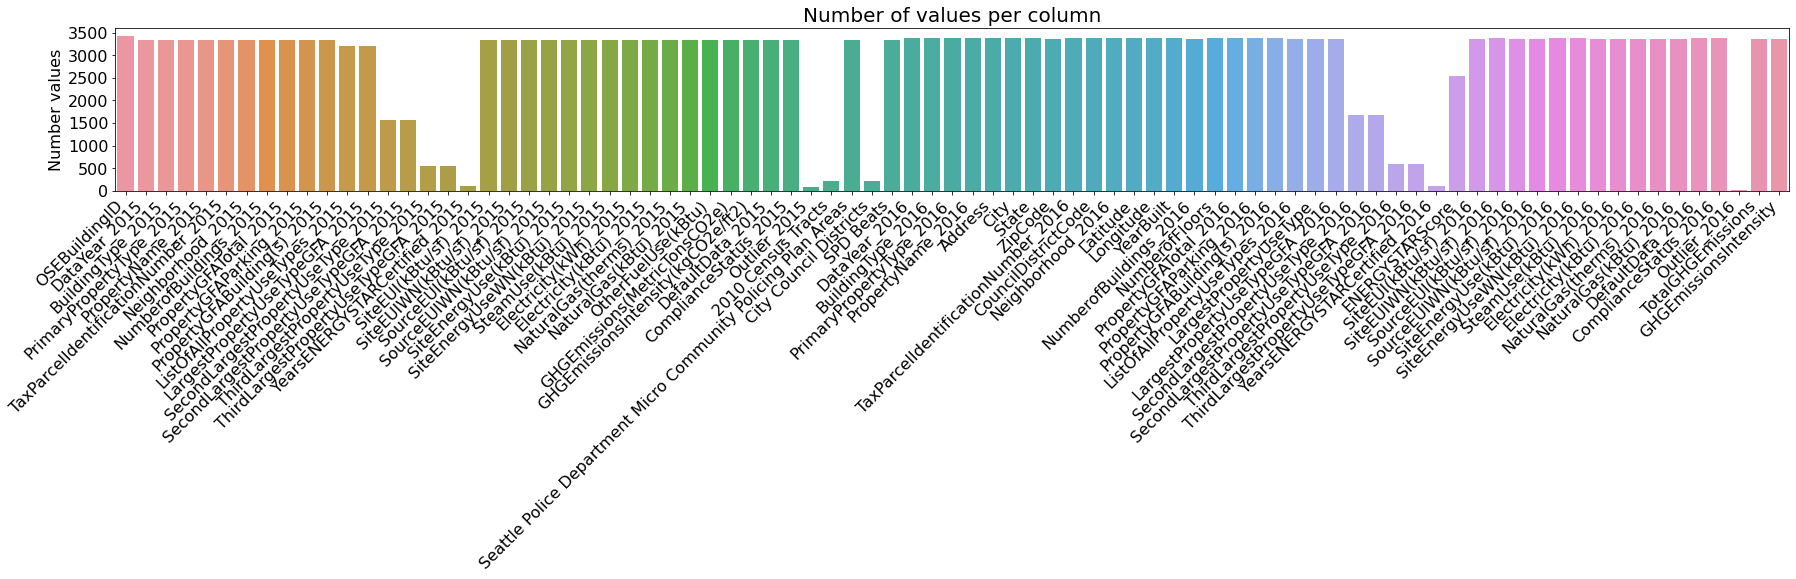

In [135]:
dataframe_distribution_overview(data, figsize=(30, 3))

***
# 4 Cleaning

## 4.1 Target

In [136]:
targets = ["SiteEnergyUse(kBtu)_2015", "SiteEnergyUse(kBtu)_2016"]

In [137]:
targets_na = data[targets].isna()
targets_na.sum()

SiteEnergyUse(kBtu)_2015    102
SiteEnergyUse(kBtu)_2016     61
dtype: int64

In [138]:
nb_rows_before_drop = data.shape[0]

In [139]:
data.dropna(subset=targets, inplace=True)

In [140]:
nb_rows_after_drop = data.shape[0]

In [141]:
targets_na = data[targets].isna()
targets_na.sum()

SiteEnergyUse(kBtu)_2015    0
SiteEnergyUse(kBtu)_2016    0
dtype: int64

In [142]:
print(f"rows dropped: {nb_rows_before_drop - nb_rows_after_drop}")

rows dropped: 160


***
## 4.1 Emptyness

In [143]:
cols_to_remove = index_lth(data, 10)

In [144]:
data.drop(columns=cols_to_remove, inplace=True)

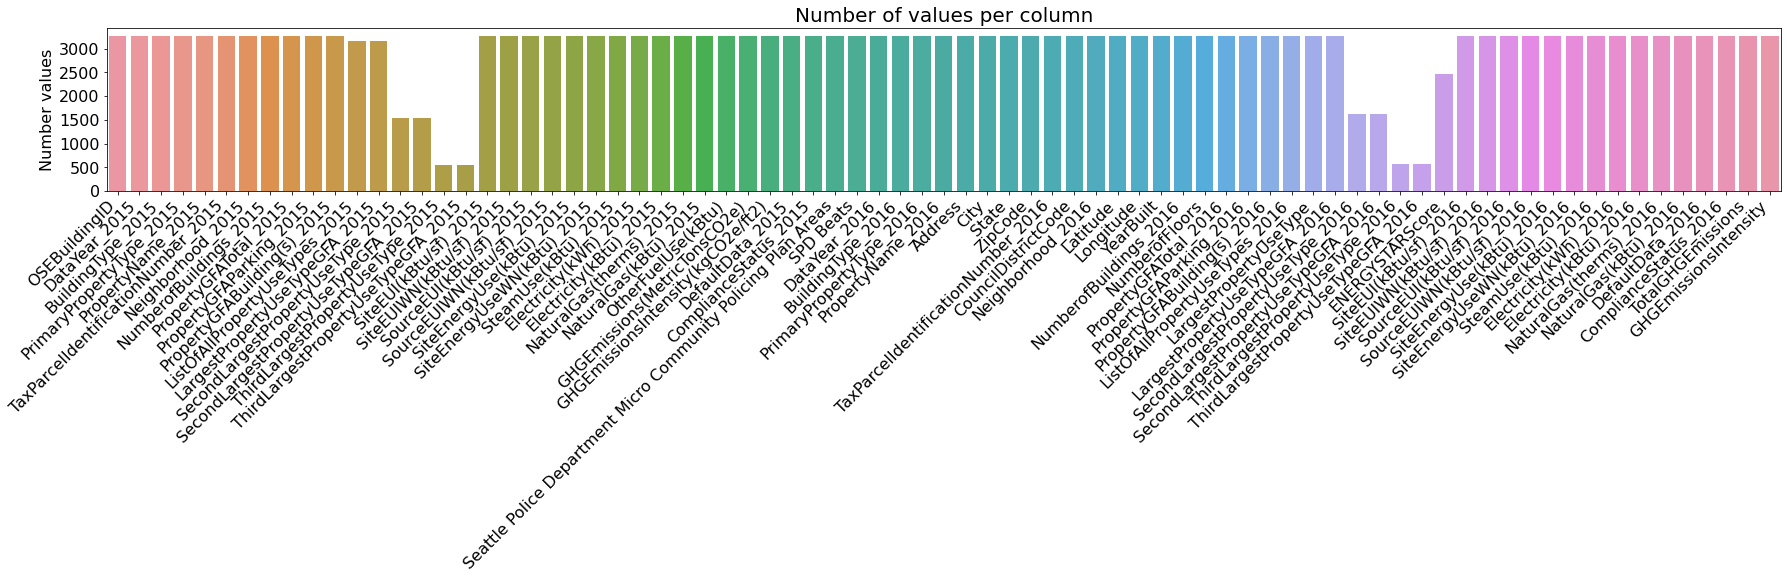

In [145]:
dataframe_distribution_overview(data, figsize=(30, 3))

***
## 4.2 Usability

### 4.2.1 Numericals

In [153]:
numerical_data = data.select_dtypes(["int64", "float64"])

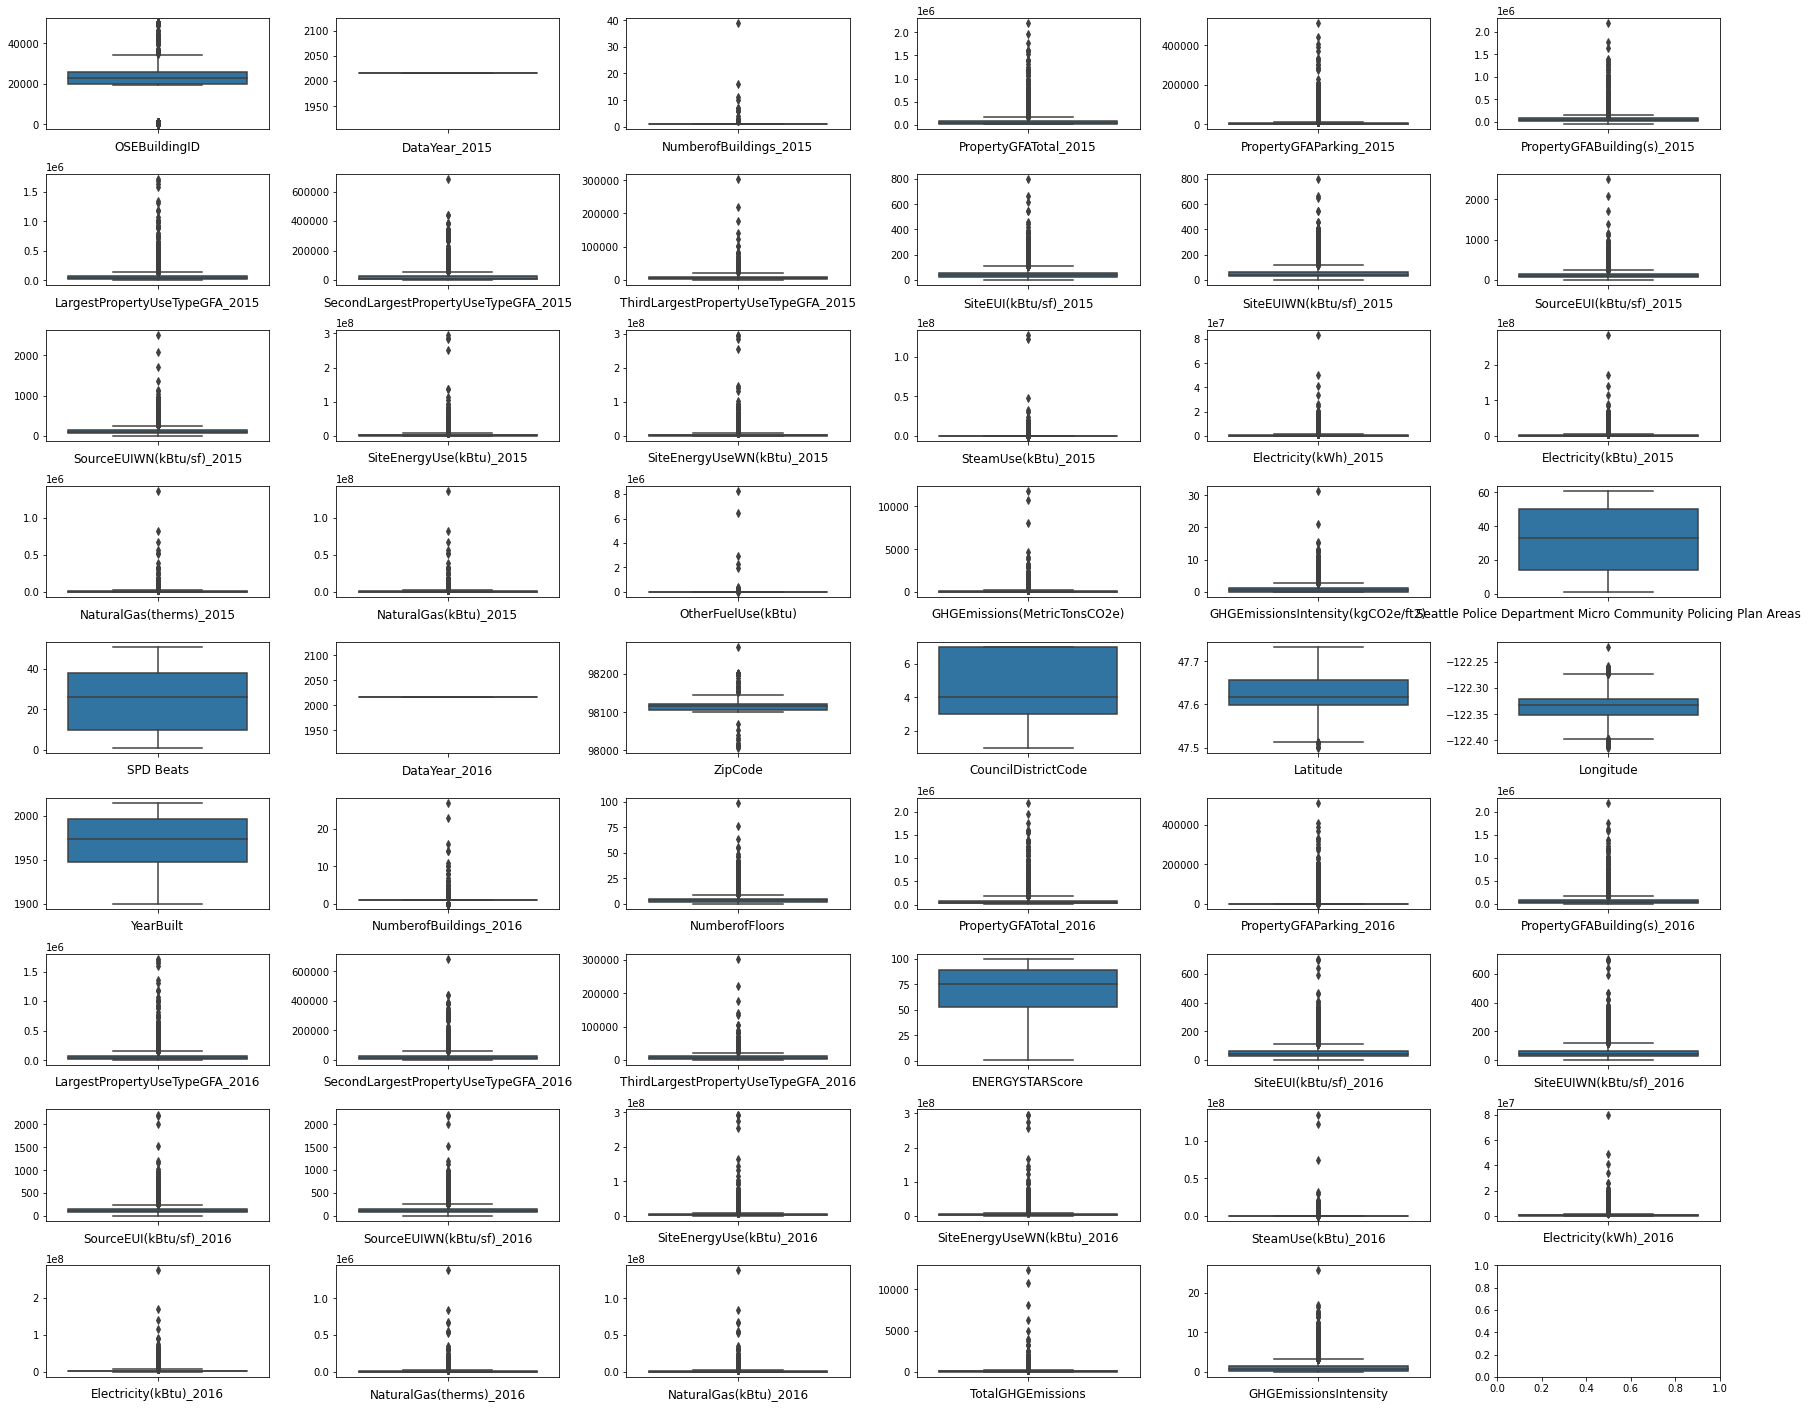

In [177]:
multi_boxplot(data, numerical_data.columns.values, n_cols=6, hspace=0.4, wspace=0.30, figsize=(30, 25))

***
### 4.2.2 Categoricals

In [178]:
categorical_data = data.select_dtypes("object")
categorical_data.describe()

,BuildingType_2015,PrimaryPropertyType_2015,PropertyName_2015,TaxParcelIdentificationNumber_2015,Neighborhood_2015,ListOfAllPropertyUseTypes_2015,SecondLargestPropertyUseType_2015,ThirdLargestPropertyUseType_2015,DefaultData_2015,ComplianceStatus_2015,BuildingType_2016,PrimaryPropertyType_2016,PropertyName_2016,Address,City,State,TaxParcelIdentificationNumber_2016,Neighborhood_2016,ListOfAllPropertyUseTypes_2016,LargestPropertyUseType,SecondLargestPropertyUseType_2016,ThirdLargestPropertyUseType_2016,DefaultData_2016,ComplianceStatus_2016
count,3272,3272,3272,3271,3272,3167,1539,554,3272,3272,3272,3272,3272,3272,3272,3272,3272,3272,3269,3259,1624,577,3272,3272
unique,7,27,3220,3180,13,436,47,41,2,1,7,23,3258,3251,1,1,3180,18,452,55,50,42,2,4
top,NonResidential,Low-Rise Multifamily,WAREHOUSE,2400002,DOWNTOWN,Multifamily Housing,Parking,Retail Store,No,Compliant,NonResidential,Low-Rise Multifamily,Northgate Plaza,309 South Cloverdale Street,Seattle,WA,0002400002,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,False,Compliant
freq,1430,972,9,5,564,854,869,105,2741,3272,1431,973,3,4,3272,3272,5,563,852,1625,939,108,3166,3122


***
# 5 Correlations

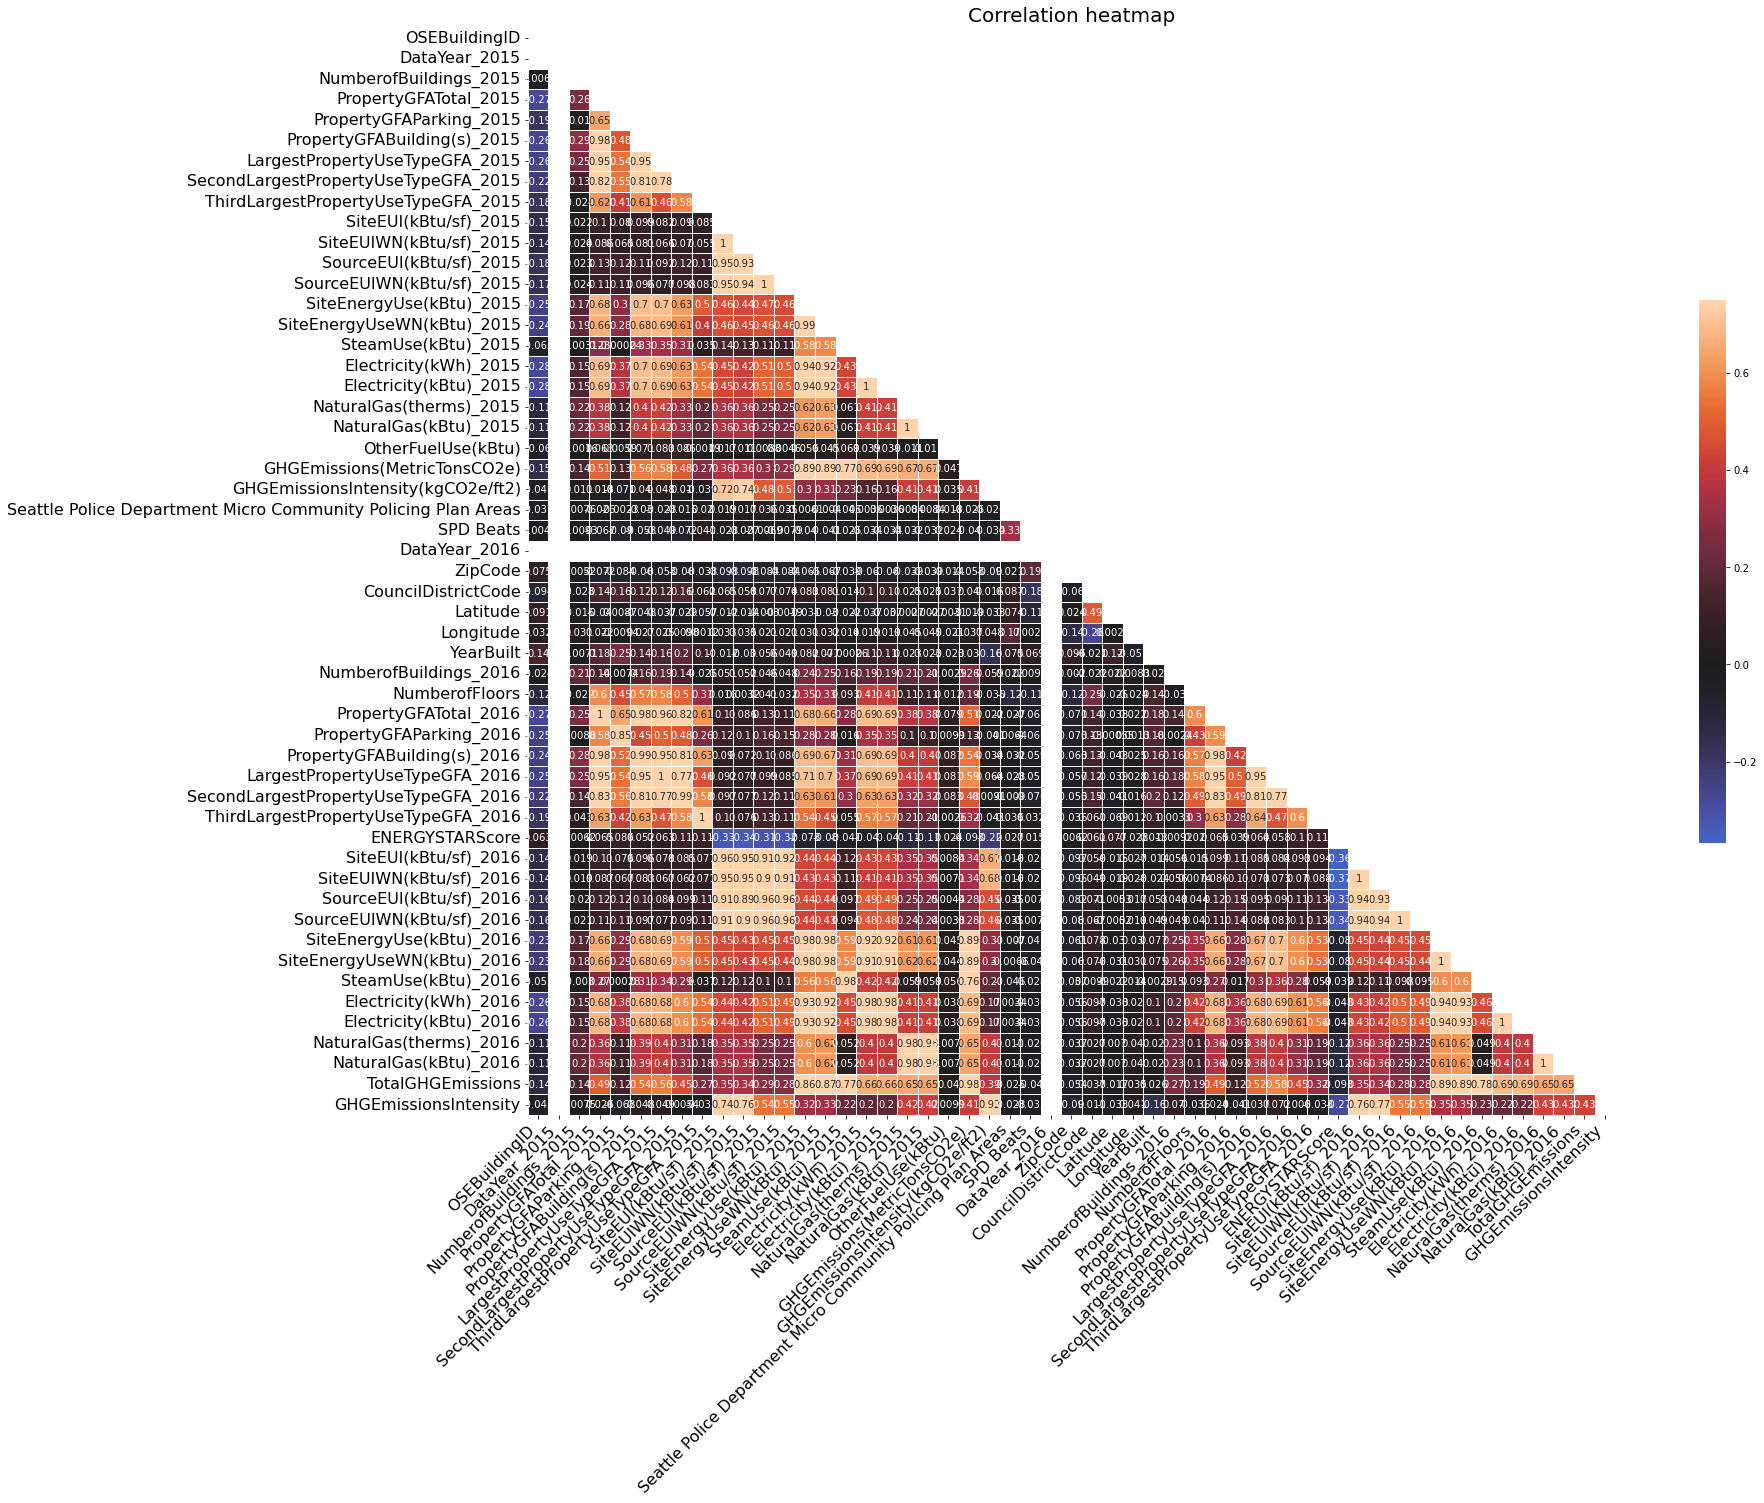

In [179]:
plt.figure(figsize=(30, 20))

correlation = data.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [180]:
categs = data.select_dtypes(include="object")

In [181]:
def categorize(feature):
    new_feature = feature.astype("category").cat.codes
    return new_feature

In [182]:
categs_to_nums = categs.apply(lambda col: categorize(col))

In [183]:
for col in categs_to_nums.columns:
    categs_to_nums.rename(columns={col: col + "_CATEG"}, inplace=True)

In [184]:
data_enhanced = data.join([categs_to_nums])

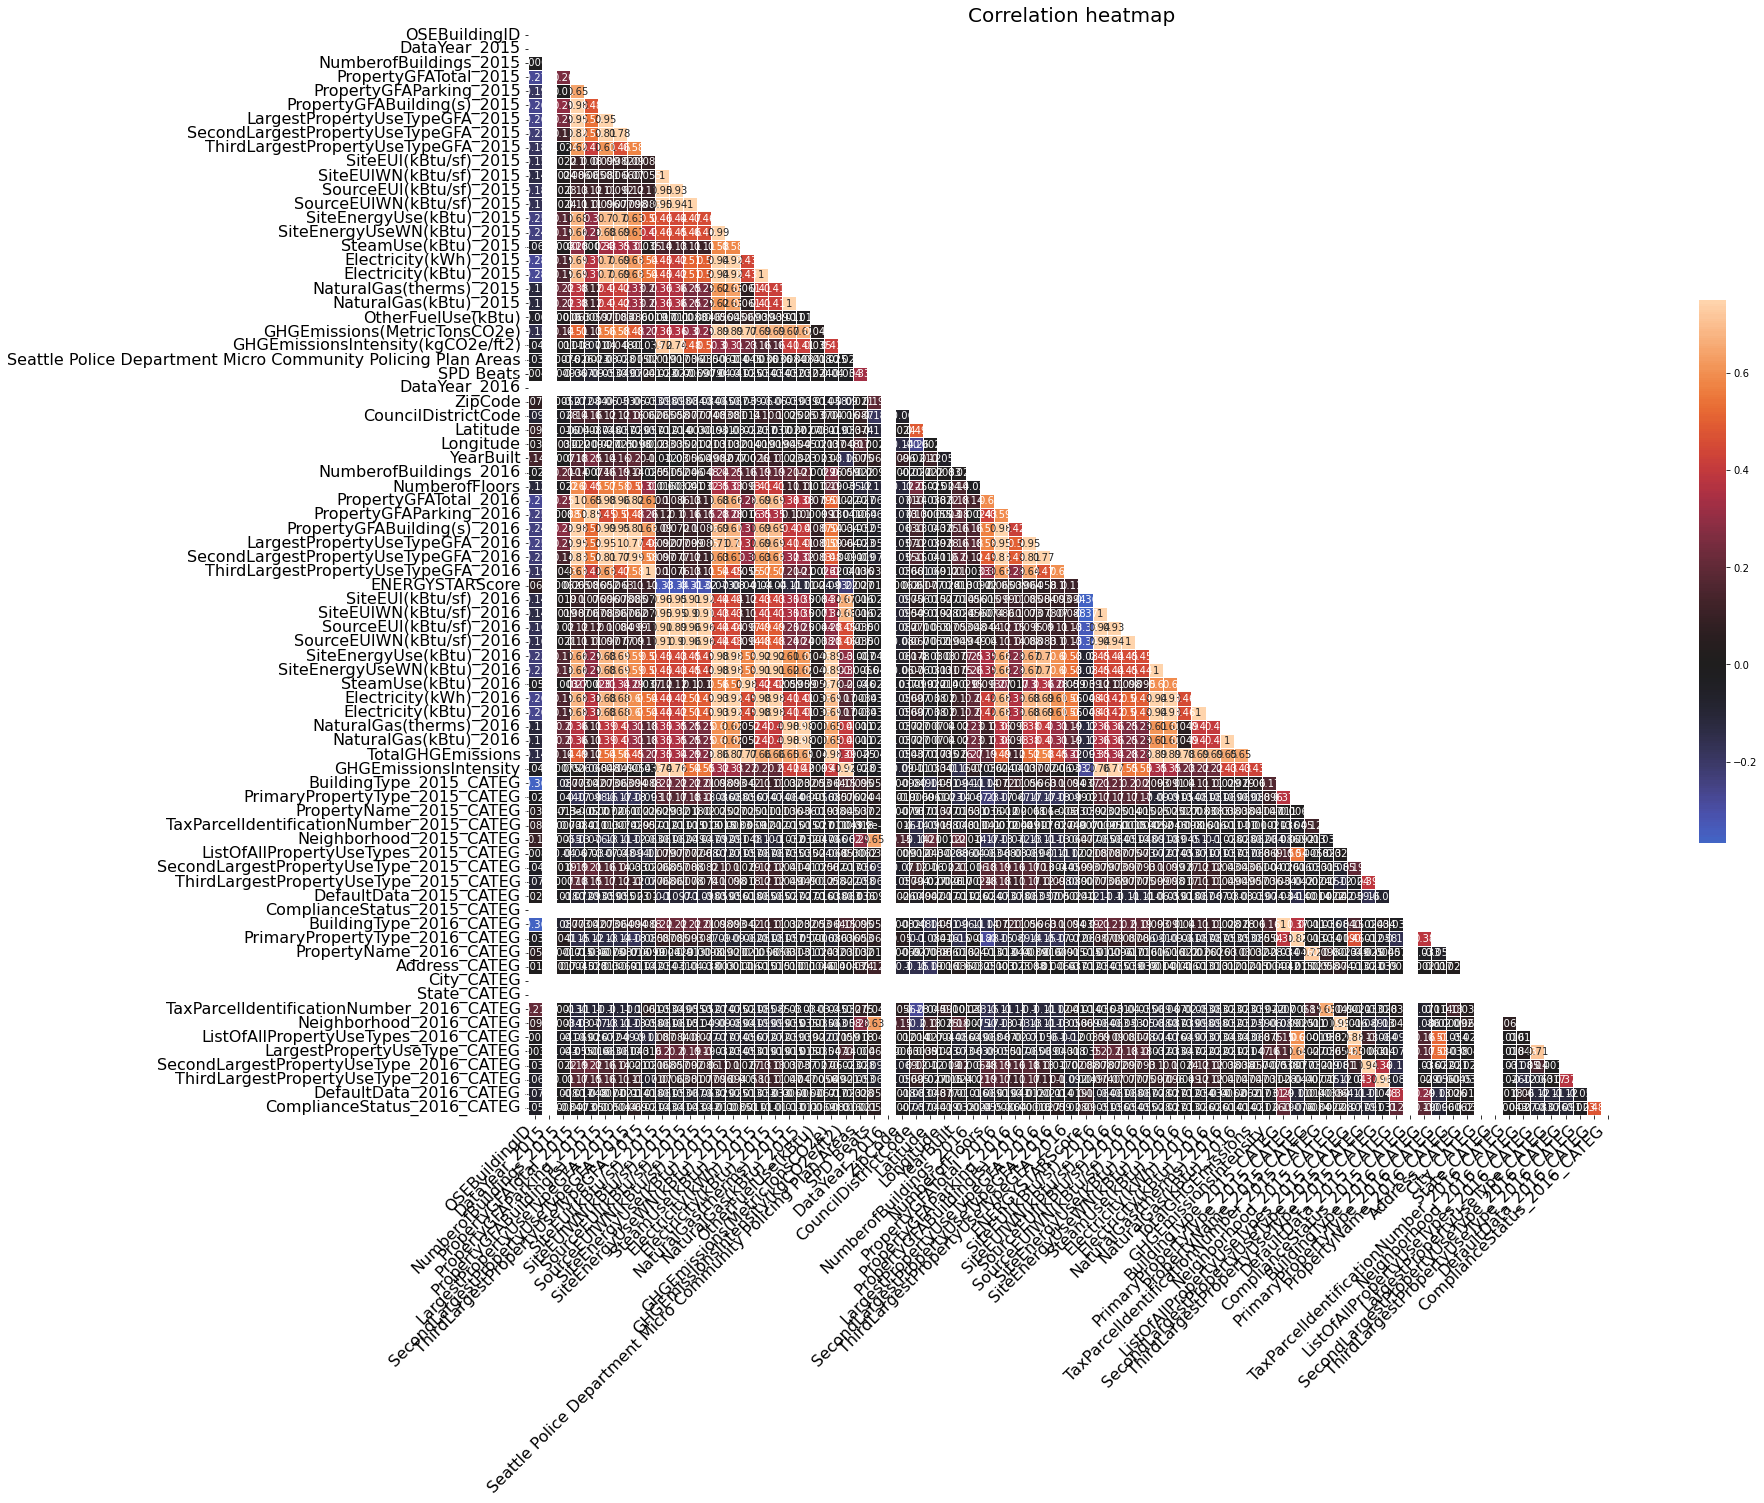

In [185]:
plt.figure(figsize=(30, 20))

correlation = data_enhanced.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation heatmap", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

***
# 6 Saving

In [186]:
data.to_csv("data/data-cleaned.csv", sep=",")

***
# 7 ...